Get the document online 

In [ ]:
! wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip

In [ ]:
! unzip stanfordSentimentTreebank.zip

In [ ]:
! rm stanfordSentimentTreebank.zip

In [2]:
import os, pickle, glob, random, time
import os.path as op

import numpy as np
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 0
%matplotlib inline

data_utils.py

deal with data format and negative sample probability

In [17]:
class StanfordSentiment:
    def __init__(self, path=None, tablesize=1000000):
        if not path:
            # path = "./stanfordSentimentTreebank"
            path = "./datasets/stanfordSentimentTreebank"

        self.path = path
        self.tablesize = tablesize
    
    def tokens(self):
        '''return the tokens (word:index) mapping
           create ind2token mapping (list)
           wordcount: total words number; token freq: just each word's count
        '''
        if hasattr(self, '_tokens') and self._tokens:
            return self._tokens

        tokens = dict()
        tokenfreq = dict()
        wordcount = 0
        revtokens = []
        idx = 0

        for sentence in self.sentences():
            for w in sentence:
                wordcount += 1
                if not w in tokens:
                    tokens[w] = idx     # NOTE: tokens 从0开始
                    revtokens += [w]
                    tokenfreq[w] = 1
                    idx += 1
                else:
                    tokenfreq[w] += 1

        tokens['UNK'] = idx
        revtokens += ['UNK']
        tokenfreq["UNK"] = 1
        wordcount += 1

        self._tokens = tokens
        self._tokenfreq = tokenfreq
        self._wordcount = wordcount
        self._revtokens = revtokens # ind2tokens, 没必要再用一个dic，直接list存储
        return self._tokens

    def sentences(self):
        '''get pure lower case words list for each sentence in the file'''
        if hasattr(self, '_sentences') and self._sentences:
            return self._sentences

        sentences = []
        with open(self.path + "/datasetSentences.txt",'r') as f:
            first = True
            for line in f:
                if first:
                    first = False
                    continue    # 第一个不做处理

                splitted = line.strip().split()[1:] # 第一个不做处理
                # Deal with some peculiar encoding issues with this file
                sentences += [[w.lower() for w in splitted]]

        self._sentences = sentences
        # self._sentlengths = np.array([len(s) for s in sentences])
        # self._cumsentlen = np.cumsum(self._sentlengths) # NOTE: ？？为什么记录cumsum

        return self._sentences

    def numSentences(self):
        '''return the number of sentences'''
        if hasattr(self, '_numSentences') and self._numSentences:
            return self._numSentences

        else:
            self._numSentences = len(self.sentences())
            return self._numSentences

    def allSentences(self):
        '''process the sentences: *0 times the original sentences, and 
            drop words with the prob based on each token's freq'''
        if hasattr(self, '_allsentences') and self._allsentences:
            return self._allsentences

        sentences = self.sentences()
        rejectProb = self.rejectProb()
        tokens = self.tokens()
        # NOTE: 先*30？？？根据拒绝率拒绝（下采样？
        allsentences = [[w for w in s if 0 >= rejectProb[tokens[w]] or random.random() >= rejectProb[tokens[w]]] for s in sentences * 30]

        allsentences = [s for s in allsentences if len(s) > 1]  # 只保留了至少有2个单词的句子

        self._allsentences = allsentences
        
        return self._allsentences

    def getRandomContext(self, C=5):
        '''get random center word and its not NULL context words'''
        allsent = self.allSentences()   # 获取了处理过的句子
        sentID = random.randint(0, len(allsent) - 1)
        sent = allsent[sentID]
        wordID = random.randint(0, len(sent) - 1)

        context = sent[max(0, wordID - C):wordID + C + 1]   # 开头结尾直接不算
        # if wordID + 1 < len(sent):
        #     context += sent[wordID + 1:min(len(sent), wordID + C + 1)]

        centerword = sent[wordID]
        # context = [w for w in context if w != centerword]   # 这样还是会把相同的词搞掉诶
        context = sent[:wordID] + sent[wordID + 1:]

        if len(context) > 0:
            return centerword, context
        else:
            return self.getRandomContex(C)  # 如果发现生成的context word为空，则直接重新生成一遍

    def sent_labels(self):
        '''return the sent-label mapping'''
        if hasattr(self, '_sent_labels') and self._sent_labels:
            return self._sent_labels
        
        dictionary = dict()
        phrases = 0
        # with open(self.path + "/dictionary.txt", 'r') as f:
        with open(self.path + "/dictionary.txt", 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line: continue   # 空行不做处理
                splitted = line.split("|")
                dictionary[splitted[0].lower()] = int(splitted[1])  # ID lookup table?
                phrases += 1
        
        labels = [0.0] * phrases
        with open(self.path + '/sentiment_labels.txt', 'r') as f:
            first = True
            for line in f:
                if first:
                    first = False
                    continue
            
                line = line.strip()
                if not line: continue
                splitted = line.split("|")
                labels[int(splitted[0])] = float(splitted[1])

        sent_labels = [0.0] * self.numSentences()
        sentences = self.sentences()
        for i in range(self.numSentences()):
            sentence = sentences[i]
            full_sent = " ".join(sentence).replace('-lrb-', '(').replace('-rrb-',')')   # ????
            sent_labels[i] = labels[dictionary[full_sent]]

        self._sent_labels = sent_labels
        return self._sent_labels

    def dataset_split(self):
        '''divide the dataset into train:dev:test according to the txt'''
        if hasattr(self, '_split') and self._split:
            return self.dataset_split
        
        split = [[] for i in range(3)]
        with open(self.path + "/datasetSplit.txt", 'r') as f:
            first = True
            for line in f:
                if first:
                    first = False
                    continue
                
                splitted = line.strip().split(',')
                split[int(splitted[1]) - 1] += [int(splitted[0]) - 1]
            
        self._split = split
        return self._split

    def getRandomTrainSentence(self):
        '''randomly choose a traindata'''
        split = self.dataset_split()
        sentId = split[0][random.randint(0, len(split[0]) - 1)]
        return self.sentences()[sentId], self.categorify(self.sent_labels()[sentId])

    def categorify(self, label):
        '''map real grade into categorical classes'''
        if label <= 0.2:   return 0
        elif label <= 0.4: return 1
        elif label <= 0.6: return 2
        elif label <= 0.8: return 3
        else: return 4

    def getDevSentences(self):
        return self.getSplitSentences(2)
    
    def getTestSentences(self):
        return self.getSplitSentences(1)
    
    def getTrainSentences(self):
        return self.getSplitSentences(0)

    def getSplitSentences(self, split=0):
        '''return the splitted data'''
        ds_split = self.dataset_split()
        return [(self.sentences()[i], self.categorify(self.sent_labels()[i])) for i in ds_split[split]]
    
    def sampleTable(self):
        '''first construct a table, then randomly choose from it'''
        if hasattr(self, '_sampleTable') and self._sampleTable is not None:
            return self._sampleTable

        nTokens = len(self.tokens())
        samplingFreq = np.zeros((nTokens,))
        self.allSentences()
        
        for i in range(nTokens):
            w = self._revtokens[i]
            if w in self._tokenfreq:
                freq = 1.0 * self._tokenfreq[w]
                # reweigh
                freq = freq ** 0.75
            else:   # NOTE: 为什么会有不在self.tokens里的单词？
                freq = 0.0
            samplingFreq[i] = freq

        samplingFreq /= np.sum(samplingFreq)
        samplingFreq = np.cumsum(samplingFreq) * self.tablesize # CDF?

        self._sampleTable = [0] * self.tablesize

        j = 0
        for i in range(self.tablesize):
            while i > samplingFreq[j]:
                j += 1
            self._sampleTable[i] = j

        # NOTE：就是原论文中提到的sample方法；先打表，然后再取对应数值
        return self._sampleTable    
    
    def rejectProb(self):
        '''assign the rejection prob to each unique token (with the same order)'''
        if hasattr(self, '_rejectProb') and self._rejectProb is not None:
            return self._rejectProb     # 为什么这里用了is not None

        threshold = 1e-5 * self._wordcount

        nTokens = len(self.tokens())
        rejectProb = np.zeros((nTokens,))
        for i in range(nTokens):
            w = self._revtokens[i]
            freq = 1.0 * self._tokenfreq[w]
            # reweight  NOTE: 为什么不用那个3/4次方的式子？
            rejectProb[i] = max(0, 1 - np.sqrt(threshold / freq))

        self._rejectProb = rejectProb
        return self._rejectProb

    def sampleTokenIdx(self):
        '''get a token index ranomly according to the negative drop out rate'''
        # 注意一下tablesize到底是啥
        return self.sampleTable()[random.randint(0, self.tablesize - 1)]


In [30]:
SAVE_PARAMS_EVERY = 5000
# path = ''
path = "../../models/C9dim10"

def load_saved_params():
    '''helper function to loads previously saved params'''
    st = 0
    for f in glob.glob(path+"saved_params_*.npy"):   # 在当前文件夹下找到所有类似的文件名
        iter = int(op.splitext(op.basename(f))[0].split("_")[2])
        if (iter > st): st = iter
    
    if st > 0:
        params_file = path+"saved_params_%d.npy" % st
        state_file = path+"saved_state_%d.pickle" % st
        params = np.load(params_file,allow_pickle=True)
        with open(state_file, "rb") as f:
            state = pickle.load(f)
        return st, params, state
    else:
        return st, None, None

def save_params(iter, params):
    params_file = path+"saved_params_%d.npy" % iter
    np.save(params_file, params)
    with open(path+"saved_state_%d.pickle" % iter, "wb") as f:
        pickle.dump(random.getstate(), f)

def sgd(f, x0, step, iterations, postprocessing=None, useSaved=False, PRINT_EVERY = 10):
    '''Stochastic Gradient Descent
       word2vec should be normalized to unit length
    '''
    ANNEAL_EVERY = 20000    # 没过这么多步，lr衰减一半

    if useSaved:
        start_iter, oldx, state = load_saved_params()
        if start_iter > 0:
            x0 = oldx
            step *= 0.5 ** (start_iter / ANNEAL_EVERY)

        if state:
            random.setstate(state)

    else:
        start_iter = 0

    x = x0

    if not postprocessing:
        postprocessing = lambda x: x

    exploss = None

    for iter in range(start_iter + 1, iterations + 1):
        loss = None
        loss, grad = f(x)
        x -= step * grad

        x = postprocessing(x)
        if iter % PRINT_EVERY == 0 or iter == 100:
            if not exploss: exploss = loss
            else: exploss = .95 * exploss + .05 * loss
            # NOTE: 只加上0.5%的新loss？

            print("iter %d: %f" % (iter, exploss))

        if iter % SAVE_PARAMS_EVERY == 0 and useSaved:
            save_params(iter, x)

        if iter % ANNEAL_EVERY == 0:
            step *= 0.5

    return x


In [5]:
def normalizeRows(x):
    '''row normalization function'''
    assert len(x.shape) <= 2
    x = x / np.sqrt(np.sum(np.power(x,2), axis=len(x.shape) -1 )).reshape(-1,1) + 1e-30
    return x

def softmax(x):
    '''compute the softmax function for each row of the input x'''
    assert len(x.shape) <= 2
    y = np.exp(x - np.max(x, axis=len(x.shape) - 1, keepdims=True))
    normalization = np.sum(y, axis=len(x.shape) - 1, keepdims=True)
    return np.divide(y, normalization)

def sigmoid(x):
    '''compute the sigmoid function for the input'''
    s = 1 / (1 + np.exp(-x))
    return s

In [6]:
def softmaxCostAndGradient(v_c, target, outputVectors, dataset):
    '''所以center word vecs只更新当前center, context word vecs会全部更新'''
    u_o = outputVectors[target, : ]     # the target outside word (1,M)
    # v_c = predicted     # center word vector (1,M)
    u_w = outputVectors # all context/outside words vectors (V,M)

    p = softmax(np.dot(u_w,v_c))    # (V,M) dot (M,1) => (V,1)
    cost = -np.log(p[target])       # target is the true outside word we want
    gradCenterVec = -u_o + np.dot(p,u_w)    # (1,M) - (V,) dot (V,M) => (1,M)
    p[target] -= 1      # deal with the u_o
    gradOutsideVecs = np.outer(p, v_c)  # (V,) outer (1,M) => (V,M)
    ### END YOUR CODE
    
    return cost, gradCenterVec, gradOutsideVecs


def negSamplingCostAndGradient(v_c, target, outputVectors, dataset, K=10):
    """ Negative sampling cost function for word2vec models """
    """ Samples K indexes which are not the outsideWordIdx """
    u_o = outputVectors[target, : ]     # the target outside word (1,M)
    # v_c = predicted     # center word vector (1,M)
    
    k_ind,_ = [],0
    while _ < K:
        new_ind = dataset.sampleTokenIdx()
        if new_ind != target:
            k_ind.append(new_ind)
            _ += 1
    

    k_ind = np.array(k_ind)
    u_k = outputVectors[k_ind]  # (K,M)

    sigmoid_o = sigmoid(np.dot(u_o, v_c))   # (1,M) dot (M,) => scaler
    sigmoid_k = sigmoid(-np.dot(u_k, v_c))  # (K,M) dot (M,) => (K,)
    cost = - np.log(sigmoid_o) - np.log(sigmoid_k).sum()

    sigmoid_o -= 1.0
    sigmoid_k = 1.0 - sigmoid_k 
    gradCenterVec = np.dot(sigmoid_o, u_o) + np.dot(sigmoid_k, u_k) # c * (1,M) + (1,K) dot (K,M) =? (1,M)

    gradOutsideVecs = np.zeros(outputVectors.shape, dtype=np.float32)
    gradOutsideVecs[target] += np.dot(sigmoid_o, v_c)    # scaler dot (M,)

    temp = np.outer(sigmoid_k, v_c)
    for i in range(len(k_ind)):
        gradOutsideVecs[k_ind[i]] += temp[i]

    # NOTE: ???为什么用下面这行会过不了gradient的check？？
    # gradOutsideVecs[k_ind] += np.outer(sigmoid_k, v_c)   # (1,K) outer (M,)
    
    return cost, gradCenterVec, gradOutsideVecs

def skipgram(currentWord, C, contextWords, tokens, centerVectors, contextVectors,
                dataset, word2vecCostAndGradient = softmaxCostAndGradient):
    """ Skip-gram model in word2vec """
    cost, gradIn, gradOut = 0, np.zeros(centerVectors.shape), np.zeros(contextVectors.shape)
    for word in contextWords:
        cur_cost, gradCenterVec, gradOutsideVecs = word2vecCostAndGradient(centerVectors[tokens[currentWord]], tokens[word], contextVectors, dataset)
        cost += cur_cost
        gradIn[tokens[currentWord]] += gradCenterVec
        gradOut += gradOutsideVecs

    return cost, gradIn, gradOut


In [7]:
def word2vec_sgd_wrapper(word2vecModel, word2Ind, wordVectors, dataset,
                         windowSize, 
                         word2vecCostAndGradient = softmaxCostAndGradient):
    ''''''
    batchsize = 50
    loss = 0.0
    grad = np.zeros(wordVectors.shape)
    N = wordVectors.shape[0]
    centerWordVectors = wordVectors[:N//2, :]
    outsideVectors = wordVectors[N//2:, :]
    for i in range(batchsize):
        # NOTE：why window size 还是随机再选一遍？
        windowSize1 = random.randint(1, windowSize)
        centerWord, context = dataset.getRandomContext(windowSize1)

        c, gin, gout = word2vecModel(
            centerWord, windowSize1, context, word2Ind, centerWordVectors,
            outsideVectors, dataset, word2vecCostAndGradient
        )
        loss += c / batchsize
        grad[:N//2,:] += gin / batchsize
        grad[N//2:, :] += gout /batchsize

    return loss, grad

Test function

In [11]:
# reset the random seed
random.seed(314)
dataset = StanfordSentiment()
tokens = dataset.tokens()
nWords = len(tokens)

# setting ups
dimVectors = 10
C = 5

# reset random seed again
random.seed(31415)
np.random.seed(9265)


In [16]:
# initialize word vectors
wordVectors = np.concatenate(
    ((np.random.rand(nWords, dimVectors) - 0.5) / dimVectors, 
      np.zeros((nWords, dimVectors))), axis=0).astype(np.float32)

startTime = time.time()
# sgd(f, x0, step, iterations, postprocessing=None, useSaved=False, PRINT_EVERY = 10)
# wordVectors = sgd(
#     lambda vec: word2vec_sgd_wrapper(skipgram, tokens, vec, dataset, C, negSamplingCostAndGradient),
#     wordVectors, 0.3, 40000, None, True, PRINT_EVERY = 1000
# )
wordVectors = sgd(
    lambda vec: word2vec_sgd_wrapper(skipgram, tokens, vec, dataset, C, negSamplingCostAndGradient),
    wordVectors, 0.3, 40000, None, False, PRINT_EVERY = 1000
)

# normalize during training loses the notion of length, so dropped here

print("sanity check: cost at convergence should be around or below 10")
print("training took %d seconds" % (time.time() - startTime))



iter 100: 28.058487
iter 1000: 28.156913
iter 2000: 28.344944
iter 3000: 28.434980
iter 4000: 28.169390
iter 5000: 27.742499
iter 6000: 27.382251
iter 7000: 26.863641
iter 8000: 26.351885
iter 9000: 25.948282
iter 10000: 25.440994
iter 11000: 25.001461
iter 12000: 24.427942
iter 13000: 23.843573
iter 14000: 23.453748
iter 15000: 23.008417
iter 16000: 22.504239
iter 17000: 22.125073
iter 18000: 21.707264
iter 19000: 21.286340
iter 20000: 20.923356
iter 21000: 20.551213
iter 22000: 20.203605
iter 23000: 19.814393
iter 24000: 19.613641
iter 25000: 19.260300
iter 26000: 18.894713
iter 27000: 18.628947
iter 28000: 18.349784
iter 29000: 18.050502
iter 30000: 17.818498
iter 31000: 17.644882
iter 32000: 17.488010
iter 33000: 17.326663
iter 34000: 17.193238
iter 35000: 16.951853
iter 36000: 16.912663
iter 37000: 16.674723
iter 38000: 16.486823
iter 39000: 16.401870
iter 40000: 16.276004
sanity check: cost at convergence should be around or below 10
training took 13380 seconds


In [18]:
! ls

'ls' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


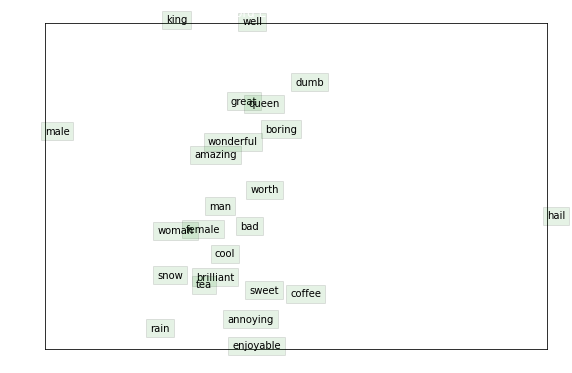

In [23]:
which_iter = 40000
params = np.load("saved_params_%d.npy" % which_iter,allow_pickle=True)
wordVectors = params

# # concatenate the input and output vectors NOTE: ???
# wordVectors = np.concatenate(
#     (wordVectors[:nWords,:], wordVectors[nWords:,:]),
#     axis=0)

# visualizeWords = ["the", "a", "an", ",", ".", "?", "!", "``", "''", "--", 
# 	"good", "great", "cool", "brilliant", "wonderful", "well", "amazing",
# 	"worth", "sweet", "enjoyable", "boring", "bad", "waste", "dumb", 
# 	"annoying"]

visualizeWords = [
    "great", "cool", "brilliant", "wonderful", "well", "amazing",
    "worth", "sweet", "enjoyable", "boring", "bad", "dumb",
    "annoying", "female", "male", "queen", "king", "man", "woman", "rain", "snow",
    "hail", "coffee", "tea"]


visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2])

# show the vectors!
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
for i in range(len(visualizeWords)):
    ax.text(coord[i,0], coord[i,1], visualizeWords[i],
        bbox=dict(facecolor='green', alpha=0.1))

ax.set_xlim((np.min(coord[:,0]), np.max(coord[:,0])))
ax.set_ylim((np.min(coord[:,1]), np.max(coord[:,1])))
ax.xaxis.label.set_color('w')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')
ax.set_title('Word Embedding Space', color='w');


# Sentiment Task

In [50]:
# path = ''
path = "D:\\universityWorks\\thirdYear\\Spring\\DISC-NLP\\pj3\\models/C8dim10"

# def load_saved_params():
#     '''helper function to loads previously saved parameters
#        plus continue to iterate
#     '''
#     st = 0
#     for f in glob.glob(path+"saved_params_*.npy"):
#         iter = int(op.splitext(op.basename(f))[0].split("_")[2])
#         print(iter)
#         if (iter > st):
#             st = iter
            
#     if st > 0:
#         with open(path+"saved_params_%d.npy" % st, "rb") as f:
#             params = pickle.load(f)
#             state = pickle.load(f)
#             # params = np.load(f)
#             # state = pickle.load(open("saved_state_%d.pickle" % st,'rb'))
#         return st, params, state
#     else:
#         print("st <= 0")
#         return st, None, None

path = "../../models/C8dim10"

def load_saved_params():
    '''helper function to loads previously saved params'''
    st = 0
    for f in glob.glob(path+"saved_params_*.npy"):   # 在当前文件夹下找到所有类似的文件名
        iter = int(op.splitext(op.basename(f))[0].split("_")[2])
        if (iter > st): st = iter
    
    if st > 0:
        params_file = path+"saved_params_%d.npy" % st
        state_file = path+"saved_state_%d.pickle" % st
        params = np.load(params_file,allow_pickle=True)
        with open(state_file, "rb") as f:
            state = pickle.load(f)
        return st, params, state
    else:
        return st, None, None

softmax regression

In [31]:
def getSentenceFeature(tokens, wordVectors, sentence):
    '''obtain the sentence feature for sentiment analysis
       by averaging its word vectors
    '''
    index = [tokens[word] for word in sentence]
    return np.mean(wordVectors[index, :], axis=0) 

def softmaxRegression(features, labels, weights, regularization = 0.0, nopredictions = False):
    '''softmax regression; 
    input:
        - features: feature vectors, each row is a feature vector
        - labels: labels corresponding to the feature vectors
        - weights: weights of the regressor
        - regularization: L2 regularization constant

    output:
        - cost: cost of the regressor
        - grad: gradient of the regressor cost with respect to its weights
        - pred: label predictions of the regressor
    '''
    prob = softmax(features.dot(weights))
    if len(features.shape) > 1:
        N = features.shape[0]
    else:
        N = 1
    
    # TODO：确认一下，是否其实还是分类器？
    cost = np.sum(-np.log(prob[range(N), labels])) / (N + 1e-30)    # 防止溢出
    cost += 0.5 * regularization * np.sum(weights ** 2) # L2 norm
    labels_onehot = np.zeros_like(prob)
    labels_onehot[range(N), labels] = 1.0
    grad = 1.0 / N * np.dot(features.T, prob - labels_onehot) + regularization * weights
    pred = np.argmax(prob, axis=len(prob.shape) - 1)
    if nopredictions:
        return cost, grad
    else:
        return cost, grad, pred
    
def accuracy(y, yhat):
    '''precison for classifier'''
    assert(y.shape == yhat.shape)
    return np.sum(y == yhat) * 100.0 / y.size   # y.size 返回数量？

def softmax_wrapper(features, labels, weights, regularization = 0.0):
    cost, grad, _ = softmaxRegression(features, labels, weights, regularization)
    return cost, grad

In [55]:
REGULARIZATION = [1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0.5]

# Load the dataset
dataset = StanfordSentiment()
tokens = dataset.tokens()
nWords = len(tokens)


which_iter = 40000
params = np.load("saved_params_%d.npy" % which_iter,allow_pickle=True)
wordVectors0 = params


# Load the word vectors we trained earlier 
# _, wordVectors0, _ = load_saved_params()
wordVectors = (wordVectors0[:nWords-2,:] + wordVectors0[nWords-2:,:])
dimVectors = wordVectors.shape[1]

# Load the train set
trainset = dataset.getTrainSentences()
nTrain = len(trainset)
trainFeatures = np.zeros((nTrain, dimVectors))
trainLabels = np.zeros((nTrain,), dtype=np.int32)
for i in range(nTrain):
    words, trainLabels[i] = trainset[i]
    trainFeatures[i, :] = getSentenceFeature(tokens, wordVectors, words)

# Prepare dev set features
devset = dataset.getDevSentences()
nDev = len(devset)
devFeatures = np.zeros((nDev, dimVectors))
devLabels = np.zeros((nDev,), dtype=np.int32)
for i in range(nDev):
    words, devLabels[i] = devset[i]
    devFeatures[i, :] = getSentenceFeature(tokens, wordVectors, words)



KeyError: 'but in imax 3-d , the clich脙漏s disappear into the vertiginous perspectives opened up by the photography .'

In [27]:
# Try our regularization parameters
import time
startTime=time.time()

results = []
for regularization in REGULARIZATION:
    random.seed(3141)
    np.random.seed(59265)
    weights = np.random.randn(dimVectors, 5)
    print("Training for reg=%f" % regularization )

    # We will do batch optimization
    weights = sgd(lambda weights: softmax_wrapper(trainFeatures, trainLabels, 
        weights, regularization), weights, 3.0, 10000, PRINT_EVERY=100)

    # Test on train set
    _, _, pred = softmaxRegression(trainFeatures, trainLabels, weights)
    trainAccuracy = accuracy(trainLabels, pred)
    print("Train accuracy (%%): %f" % trainAccuracy)

    # Test on dev set
    _, _, pred = softmaxRegression(devFeatures, devLabels, weights)
    devAccuracy = accuracy(devLabels, pred)
    print("Dev accuracy (%%): %f" % devAccuracy)

    # Save the results and weights
    results.append({
        "reg" : regularization, 
        "weights" : weights, 
        "train" : trainAccuracy, 
        "dev" : devAccuracy})
    

# Print the accuracies
print(" took %d seconds" % (time.time() - startTime))
print("")
print("=== Recap ===")
print("Reg\t\tTrain\t\tDev")
for result in results:
    print("%E\t%f\t%f" % (result["reg"],result["train"],result["dev"]))
print()


Training for reg=0.000000


NameError: name 'trainFeatures' is not defined

In [ ]:
# Pick the best regularization parameters
BEST_IND = np.argmax([result["dev"] for result in results])
BEST_REGULARIZATION = results[BEST_IND]['reg']
BEST_WEIGHTS = results[BEST_IND]['weights']

# Test your findings on the test set
testset = dataset.getTestSentences()
nTest = len(testset)
testFeatures = np.zeros((nTest, dimVectors))
testLabels = np.zeros((nTest,), dtype=np.int32)
for i in range(nTest):
    words, testLabels[i] = testset[i]
    testFeatures[i, :] = getSentenceFeature(tokens, wordVectors, words)

_, _, pred = softmaxRegression(testFeatures, testLabels, BEST_WEIGHTS)
print("Best regularization value: %E" % BEST_REGULARIZATION)
print("Test accuracy (%%): %f" % accuracy(testLabels, pred))

# Make a plot of regularization vs accuracy
plt.plot(REGULARIZATION, [x["train"] for x in results])
plt.plot(REGULARIZATION, [x["dev"] for x in results])
plt.xscale('log')
plt.xlabel("regularization")
plt.ylabel("accuracy")
plt.legend(['train', 'dev'], loc='upper left')
plt.savefig("reg_acc.png")
plt.show()